In [1]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data
data = {
    "Pregnancies": np.random.randint(0, 15, 400),
    "Glucose": np.random.randint(50, 200, 400),
    "BloodPressure": np.random.randint(30, 120, 400),
    "SkinThickness": np.random.randint(10, 70, 400),
    "Insulin": np.random.randint(20, 300, 400),
    "BMI": np.round(np.random.uniform(15, 50, 400), 1),
    "DiabetesPedigreeFunction": np.round(np.random.uniform(0.1, 2.5, 400), 3),
    "Age": np.random.randint(20, 80, 400),
    "Outcome": np.random.choice([0, 1], 400, p=[0.65, 0.35])  # 65% non-diabetic, 35% diabetic
}

# Create DataFrame
diabetes_df = pd.DataFrame(data)

# Save to CSV
diabetes_df.to_csv("diabetes.csv", index=False)

print("Sample diabetes.csv dataset created.")


Sample diabetes.csv dataset created.


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
    classification_report,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
import warnings

warnings.filterwarnings("ignore")


In [17]:
# Load data
diab = pd.read_csv("diabetes.csv")

# Replace 0s with NaN for specific columns
columns_to_impute = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in columns_to_impute:
    diab[col] = diab[col].replace(0, np.nan)

# Impute missing values with the median
for col in columns_to_impute:
    diab[col].fillna(diab[col].median(), inplace=True)

# Features and labels split
X = diab.iloc[:, :-1]
y = diab.iloc[:, -1]

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.1, stratify=y, random_state=42
)


In [18]:
# Calculate all 15 metrics
def calculate_metrics(y_true, y_pred, y_prob=None):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    fpr = fp / (tn + fp) if (tn + fp) > 0 else 0
    fnr = fn / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1_score = (2 * tp) / (2 * tp + fp + fn) if (tp + fp + fn) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    error_rate = 1 - accuracy
    bacc = (tpr + tnr) / 2
    tss = tpr - fpr
    hss = 2 * (tp * tn - fp * fn) / ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn))
    auc_score = roc_auc_score(y_true, y_prob) if y_prob is not None else None
    return {
        "TP": tp,
        "TN": tn,
        "FP": fp,
        "FN": fn,
        "TPR": tpr,
        "TNR": tnr,
        "FPR": fpr,
        "FNR": fnr,
        "Precision": precision,
        "F1-Score": f1_score,
        "Accuracy": accuracy,
        "Error Rate": error_rate,
        "BACC": bacc,
        "TSS": tss,
        "HSS": hss,
        "AUC": auc_score,
    }

# Train and evaluate a model
def train_evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    return calculate_metrics(y_test, y_pred, y_prob)

# Plot ROC Curve
def plot_roc_curve(y_true, y_prob, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

# Display Metrics in a Heatmap
def display_metrics_heatmap(metrics_df):
    plt.figure(figsize=(12, 8))
    sns.heatmap(metrics_df.T, annot=True, fmt=".2f", cmap="YlGnBu", cbar=False)
    plt.title("Metrics Comparison Across Models")
    plt.ylabel("Metrics")
    plt.xlabel("Models")
    plt.show()


In [20]:
# Naive Bayes
nb_model = GaussianNB()
nb_metrics = train_evaluate_model(nb_model, X_train, X_test, y_train, y_test)

# KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_metrics = train_evaluate_model(knn_model, X_train, X_test, y_train, y_test)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_metrics = train_evaluate_model(rf_model, X_train, X_test, y_train, y_test)

# GRU
X_train_gru = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_gru = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
gru_model = Sequential()
gru_model.add(GRU(64, input_shape=(X_train_gru.shape[1], 1), activation="relu"))
gru_model.add(Dense(1, activation="sigmoid"))
gru_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
gru_model.fit(X_train_gru, y_train, epochs=50, verbose=0)
y_prob_gru = gru_model.predict(X_test_gru).flatten()
y_pred_gru = (y_prob_gru > 0.5).astype(int)
gru_metrics = calculate_metrics(y_test, y_pred_gru, y_prob_gru)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


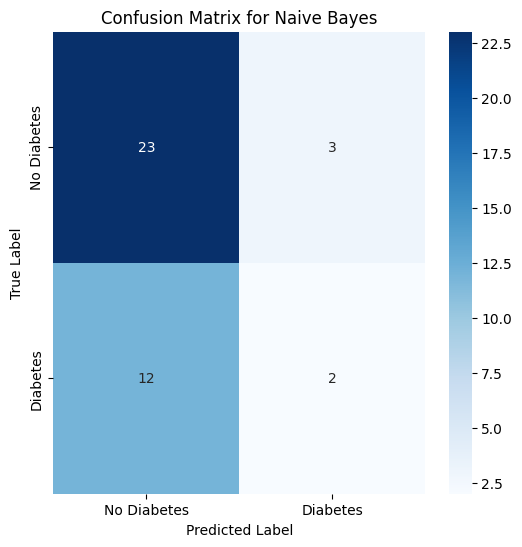

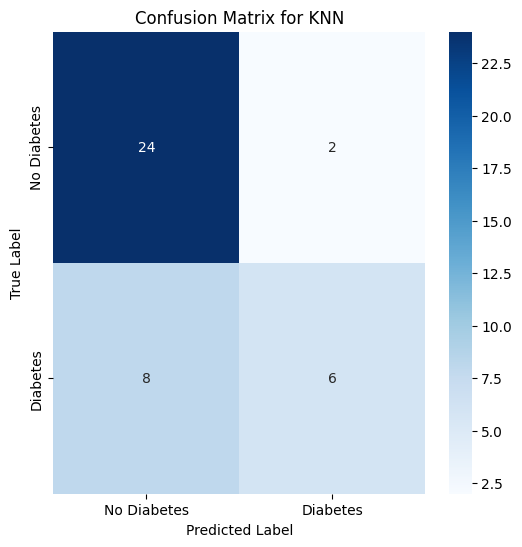

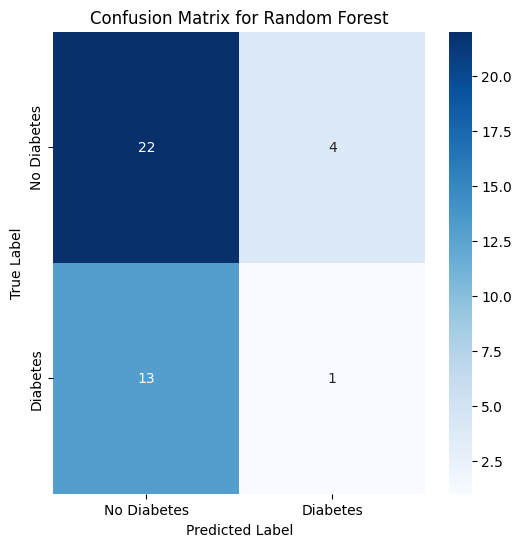

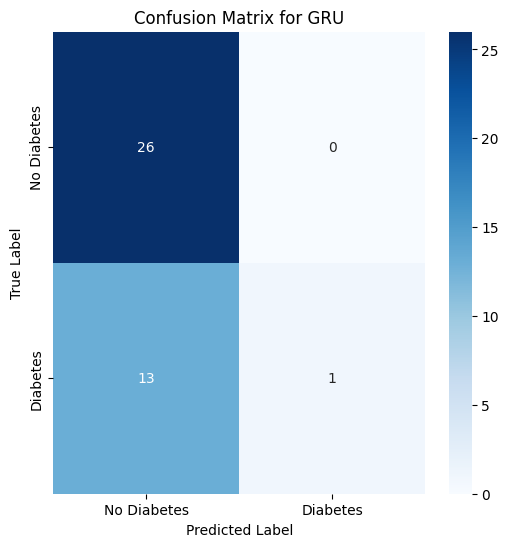

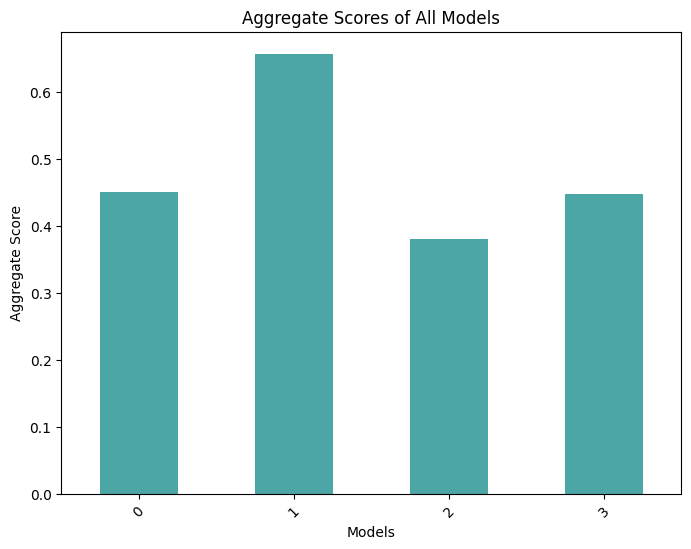

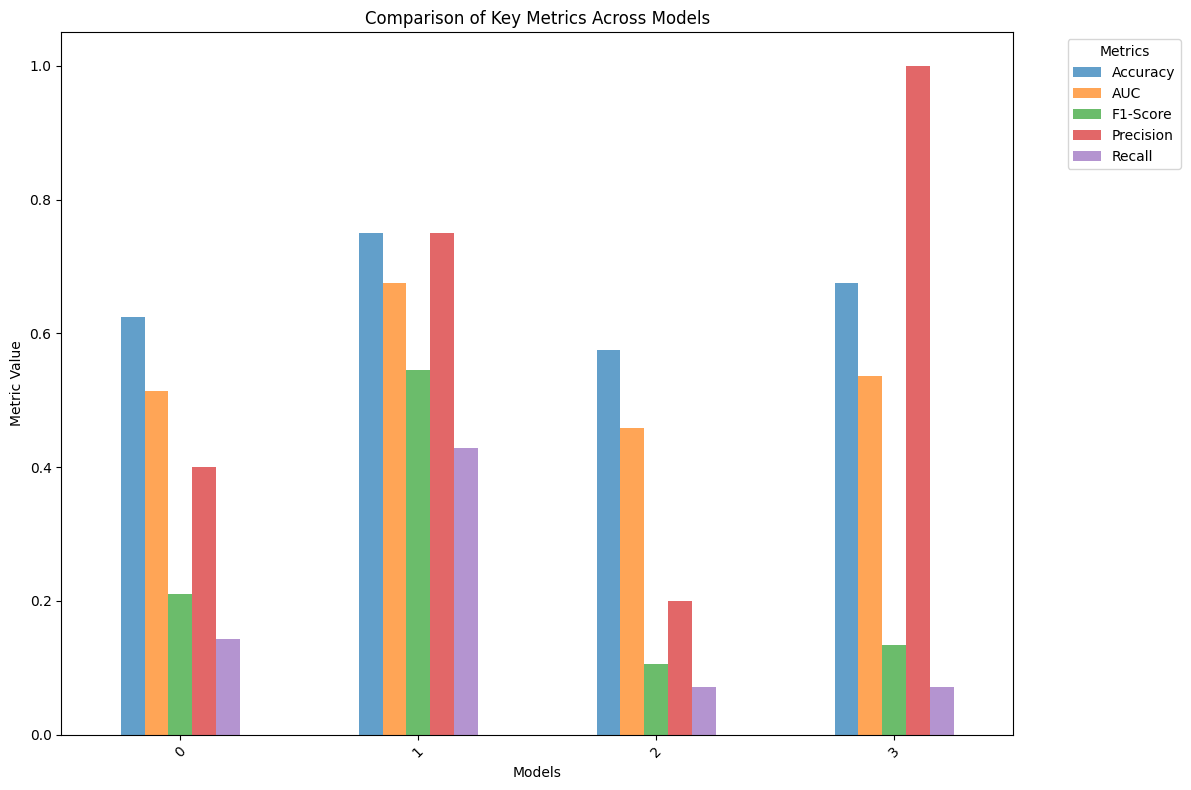

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Assuming models are already trained (nb_model, knn_model, rf_model) and dataset is split into X_train, X_test, y_train, y_test

# Example: Calculate metrics for each model
y_pred_nb = nb_model.predict(X_test)
y_pred_knn = knn_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_gru = (y_prob_gru > 0.5).astype(int)

# Calculate metrics for each model
accuracy_nb = accuracy_score(y_test, y_pred_nb)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_gru = accuracy_score(y_test, y_pred_gru)

precision_nb = precision_score(y_test, y_pred_nb)
precision_knn = precision_score(y_test, y_pred_knn)
precision_rf = precision_score(y_test, y_pred_rf)
precision_gru = precision_score(y_test, y_pred_gru)

recall_nb = recall_score(y_test, y_pred_nb)
recall_knn = recall_score(y_test, y_pred_knn)
recall_rf = recall_score(y_test, y_pred_rf)
recall_gru = recall_score(y_test, y_pred_gru)

f1_nb = f1_score(y_test, y_pred_nb)
f1_knn = f1_score(y_test, y_pred_knn)
f1_rf = f1_score(y_test, y_pred_rf)
f1_gru = f1_score(y_test, y_pred_gru)

# ROC AUC requires probabilities; ensure this is calculated correctly.
auc_nb = roc_auc_score(y_test, y_pred_nb)  # Use predicted probabilities if required
auc_knn = roc_auc_score(y_test, y_pred_knn)
auc_rf = roc_auc_score(y_test, y_pred_rf)
auc_gru = roc_auc_score(y_test, y_pred_gru)

# Ensure all calculated metrics are numeric (float) type
metrics_df = pd.DataFrame({
    'Model': ['Naive Bayes', 'KNN', 'Random Forest', 'GRU'],
    'Accuracy': [accuracy_nb, accuracy_knn, accuracy_rf, accuracy_gru],
    'Precision': [precision_nb, precision_knn, precision_rf, precision_gru],
    'Recall': [recall_nb, recall_knn, recall_rf, recall_gru],
    'F1-Score': [f1_nb, f1_knn, f1_rf, f1_gru],
    'AUC': [auc_nb, auc_knn, auc_rf, auc_gru],
})

# Convert all metrics columns to float, if they are not already
metrics_df[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']] = metrics_df[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']].astype(float)

# Calculate aggregate score (mean of selected metrics)
metrics_df["Aggregate Score"] = metrics_df[["Accuracy", "AUC", "F1-Score"]].mean(axis=1)

# Now you can plot the results
# Function to plot confusion matrices
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Diabetes", "Diabetes"],
                yticklabels=["No Diabetes", "Diabetes"])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Plot Bar Chart of Aggregate Scores
def plot_aggregate_scores(metrics_df):
    plt.figure(figsize=(8, 6))
    metrics_df["Aggregate Score"].plot(kind="bar", color="teal", alpha=0.7)
    plt.title("Aggregate Scores of All Models")
    plt.ylabel("Aggregate Score")
    plt.xlabel("Models")
    plt.xticks(rotation=45)
    plt.show()

# Plot Individual Metric Comparison
def plot_individual_metrics(metrics_df):
    metrics_to_plot = ["Accuracy", "AUC", "F1-Score", "Precision", "Recall"]
    metrics_df[metrics_to_plot].plot(kind="bar", figsize=(12, 8), alpha=0.7)
    plt.title("Comparison of Key Metrics Across Models")
    plt.ylabel("Metric Value")
    plt.xlabel("Models")
    plt.xticks(rotation=45)
    plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# Visualizing the results
# Confusion Matrices for each model
models = {
    "Naive Bayes": nb_model,
    "KNN": knn_model,
    "Random Forest": rf_model,
    "GRU": None,  # GRU uses different prediction logic
}

# Plot confusion matrices for each model
for model_name, model in models.items():
    if model is not None:
        y_pred = model.predict(X_test)
    else:  # For GRU
        y_pred = (y_prob_gru > 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, model_name)

# Aggregate Score Comparison
plot_aggregate_scores(metrics_df)

# Individual Metrics Comparison
plot_individual_metrics(metrics_df)


Metrics for All Models:
                TP    TN   FP    FN       TPR       TNR       FPR       FNR  \
Naive Bayes    2.0  23.0  3.0  12.0  0.142857  0.884615  0.115385  0.857143   
KNN            6.0  24.0  2.0   8.0  0.428571  0.923077  0.076923  0.571429   
Random Forest  1.0  22.0  4.0  13.0  0.071429  0.846154  0.153846  0.928571   
GRU            1.0  26.0  0.0  13.0  0.071429  1.000000  0.000000  0.928571   

               Precision  F1-Score  Accuracy  Error Rate      BACC       TSS  \
Naive Bayes         0.40  0.210526     0.625       0.375  0.513736  0.027473   
KNN                 0.75  0.545455     0.750       0.250  0.675824  0.351648   
Random Forest       0.20  0.105263     0.575       0.425  0.458791 -0.082418   
GRU                 1.00  0.133333     0.675       0.325  0.535714  0.071429   

                    HSS       AUC  Aggregate Score  
Naive Bayes    0.032258  0.664835         0.500120  
KNN            0.390244  0.697802         0.664419  
Random Forest -0.096

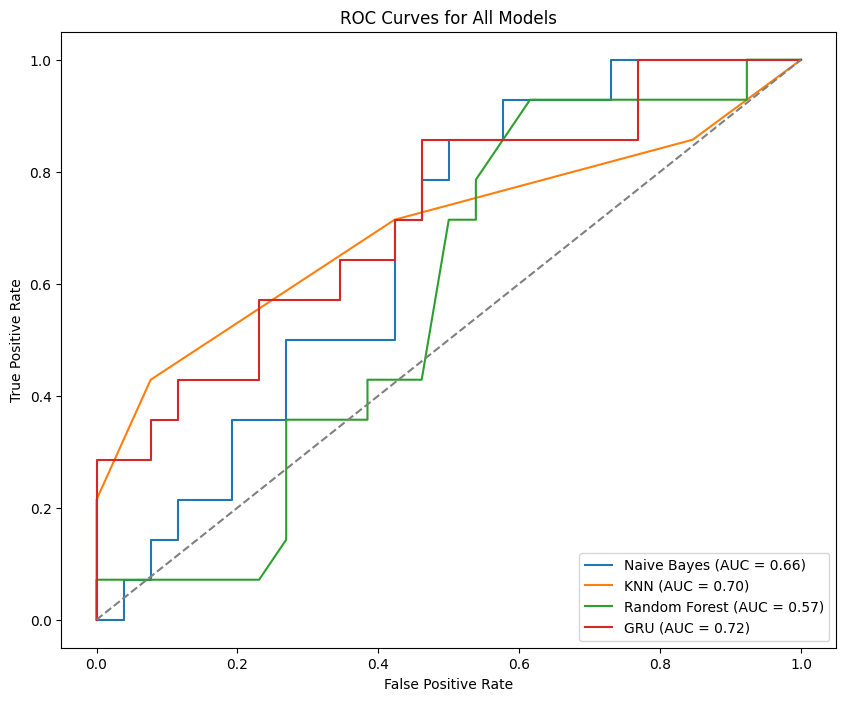

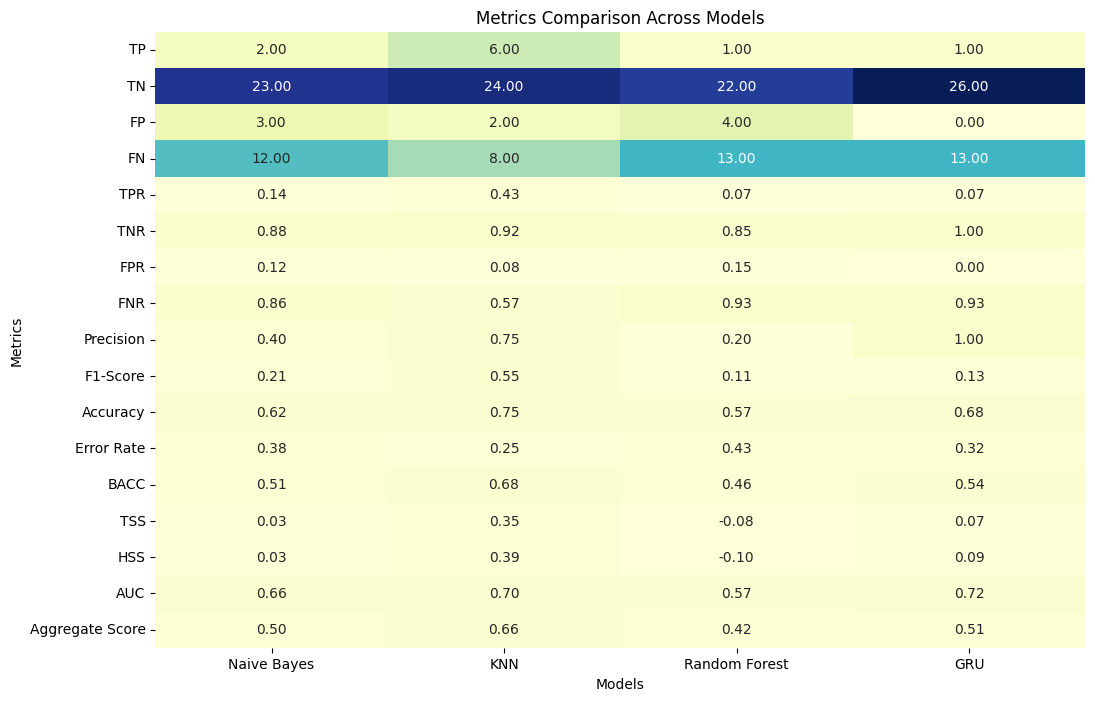

In [15]:
# Combine all metrics into a DataFrame
metrics_df = pd.DataFrame({
    "Naive Bayes": nb_metrics,
    "KNN": knn_metrics,
    "Random Forest": rf_metrics,
    "GRU": gru_metrics,
}).T

# Define the metrics for ranking the models
scoring_metrics = ["Accuracy", "AUC", "F1-Score"]

# Normalize and calculate aggregate score for each model
metrics_df["Aggregate Score"] = metrics_df[scoring_metrics].mean(axis=1)

# Determine the best model
best_model = metrics_df["Aggregate Score"].idxmax()
best_model_metrics = metrics_df.loc[best_model]

# Print metrics DataFrame
print("Metrics for All Models:")
print(metrics_df)

# Print the best model
print(f"\n\033[1;103mThe best model is: {best_model}\033[0m")
print(f"Metrics for the best model:\n{best_model_metrics}")

# Import required libraries
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc  # Ensure auc is imported from sklearn.metrics

# Ensure that no variable is named 'auc', to avoid conflict

# Function to plot ROC curves for each model
def plot_roc_curve(y_true, y_prob, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)  # Calculate AUC
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

# Plot ROC Curves
plt.figure(figsize=(10, 8))
plot_roc_curve(y_test, nb_model.predict_proba(X_test)[:, 1], "Naive Bayes")
plot_roc_curve(y_test, knn_model.predict_proba(X_test)[:, 1], "KNN")
plot_roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1], "Random Forest")
plot_roc_curve(y_test, y_prob_gru, "GRU")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curves for All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Display Metrics as Heatmap
display_metrics_heatmap(metrics_df)
